In [1]:
# import
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import time
import scipy.io
from scipy import interpolate
from commands import getoutput as cmd
import scipy.optimize
import shutil
import scipy as sp
from  scipy.ndimage.filters import gaussian_filter
import os
import matplotlib.gridspec as gridspec
import pandas as pd
import cmocean
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
def myfloat(b):
    
    try: 
        b = float(b)
    except ValueError:        
        b = [b for b in b.split('-') if b]
        b = float(b[0])*10**(-float(b[1]))
    return b


In [2]:
%matplotlib inline

In [3]:
# import python packages and inline animation functions
import matplotlib as mpl
from matplotlib.pylab import plot, pcolor, imshow
from matplotlib import animation

def _blit_draw(self, artists, bg_cache):
    # Handles blitted drawing, which renders only the artists given instead
    # of the entire figure.
    updated_ax = []
    for a in artists:
        # If we haven't cached the background for this axes object, do
        # so now. This might not always be reliable, but it's an attempt
        # to automate the process.
        if a.axes not in bg_cache:
            # bg_cache[a.axes] = a.figure.canvas.copy_from_bbox(a.axes.bbox)
            # change here
            bg_cache[a.axes] = a.figure.canvas.copy_from_bbox(a.axes.figure.bbox)
        a.axes.draw_artist(a)
        updated_ax.append(a.axes)

    # After rendering all the needed artists, blit each axes individually.
    for ax in set(updated_ax):
        # and here
        # ax.figure.canvas.blit(ax.bbox)
        ax.figure.canvas.blit(ax.figure.bbox)
# MONKEY PATCH!!
animation.Animation._blit_draw = _blit_draw
from tempfile import NamedTemporaryFile


VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
 Your browser does not support the video tag.
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264'])
            video = open(f.name, "rb").read()
        anim._encoded_video = video.encode("base64")

    return VIDEO_TAG.format(anim._encoded_video)

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))


## Part 1. Functions for analytical hydrograph and GW

In [4]:
# misc functions
def pretty_axes(titlestr, figsize = (8, 4.25)):
    fig = plt.figure(figsize = figsize)
    gs = gridspec.GridSpec(5, 1)
    ax = plt.subplot(gs[0:4, :])
    ttl = plt.suptitle(titlestr, fontsize = 10.); ttl.set_y(0.12)
    ax.annotate('', xy=(-.15, -0.22), xycoords='axes fraction', xytext=(1.1, -0.22), 
            arrowprops=dict(arrowstyle="-", color='k', ls = '-.'))
    return fig

 

def subfolder():
    subfolder = '{0}/single'.format(folder)
    return subfolder   

def fVstr(ifricV ):
    if ifricV == 1:
        return 'fV=Manning{0}'.format(xnv)
    
    elif ifricV == 2:
        return  'fV=Cd-array{0}'.format(pveg)        

    elif ifricV == 3:
        return  'fV=Poggi'
        
    elif ifricV == 10:
        return  'fV=Kirstetter'
    
    elif ifricV == 11:
        return  'fV=DW17'    

    elif ifricV == 12:
        return  'fV=Poisseuille' 
    
    else:   
        return  'fV=test'
    

def fBstr(ifricB):
    
    if ifricB == 1:
        return 'fB=Manning{0}'.format(xni)

    elif ifricB == 2:
        return  'fB=Cd-array{0}'.format(pveg)        

    elif ifricB == 3:
        return  'fB=Poggi'
              
    elif ifricB == 10:
        return  'fB=Kirstetter'
    
    elif ifricB == 11:
        return  'fB=DW_17'    

    elif ifricB == 12:
        return  'fB=Poisseuille' 
    else:
        return  'fV=test'
    
    
def ftype(fnum):
    if fnum == 1:
        return 'Manning'

    elif fnum == 2:
        return  'Cd-array'

    elif fnum == 3:
        return  'Poggi'
    
    
    elif fnum == 10:
        return  'Kirstetter' 
    
    elif fnum == 11:
        return  'DW17'    

    elif fnum == 12:
        return  'Poisseuille'
    else:
      return 'Cd-test'
    

In [5]:
import sys
sys.path.append('modelfunctions/' )
mymodules = ['misc_fxns', 
             'GWfunctions' ]
for mymod in mymodules:
    if mymod in sys.modules:  
        del sys.modules[mymod]

# from GWfunctions import *
# from analytic_fxns import *
# from output_dry import *
from misc_fxns import *

## Part S: single run with summary
compare hydrograph to GW or analytical 

In [6]:
# level   = 'A2_log_veg'

# level  = 'B1_plane_stripe1HL_Sf'
#
# level = 'B1_plane_stripe2HL_Sf'; 
# level = 'B1i_plane_stripe1HL_infl';

# level = 'B2i_log_upslope_Sf'
# level = 'B2_plane_randv_Sf';
# level = 'B2i_plane_randv_Sf'

# level = 'B2_log_upslope_Sf'

# level = 'C2i_log_upslope_Sf,infl'
# level = 'C2_Sf,infl_randv'
# level = 'C2i_plane_randv_Sf,infl'

# level = 'R_flat_stripe1HL_infl' 
# level = 'R_flat_veg_infl' 

# append = '({0})'.format(iscale)
# append = '({0})'.format(fVstr(ifricV)) 
# append = '({0})'.format(topo) 

In [7]:
# # Save a dictionary into a pickle file.
# import pickle
# level = 'B2_plane_randv_Sf'
# params = { 'ncol' : 10, 'nrow' : 50,
#         'dx' : 1., 'epsh' : .0002,
#         'dt_sw'  : .05, 'tmax'  : 60*60., 
#         'tr' : 20*60., 'rain' : 0.036/3600.,
#         'ifricV': 1, 'ifricB': 1,
#         'xnv' : 0.09, 'xni' : 0.02,
#         'pveg' : .3, 'Dveg' : 8e-3,
#         'itype1' : 0, 'itype3' : 1, 
#         'itype2' : 1, 'itype4' : 1,
#         'beta' : 1.0,       
#         'slope' : 0.01, 'logscale' : 10,     
#         'seed' : 5, 'runmodel' : 0,
#         'append' : '',
#         'iscouple': 0,
#         'stop_tol'  : 1e-2, 'iscale' : 100,
#         'htop'  : 0, 'infL'  : 2,
#         'ponding' : 1, 'dz' : .4,    # [cm]
#         'zmin' : 0. , 'zmax' : 20.,  # [cm]
#         'hinit' : -100, 'depth'  : 0., # cm
#         'ksatB' : 0.2/3600, 'ksatV' : 3./3600, 
#         'zs' : 20, 'level' : level,
#           } 

# level = 'R_flat_stripe1HL_infl' 

# params = { 'ncol' : 2, 'nrow' : 4,
#             'dx' : 1., 'epsh' : .0002,
#             'dt_sw'  : .05, 'tmax'  : 60*60., 
#             'tr' : 20*60., 'rain' : 0.036/3600.,
#             'ifricV': 1, 'ifricB': 1,
#             'xnv' : 0.09, 'xni' : 0.02,
#             'pveg' : .3, 'Dveg' : 8e-3,
#             'itype1' : 0, 'itype3' : 1, 
#             'itype2' : 1, 'itype4' : 1,
#             'beta' : 1.0,       
#             'slope' : 0.0, 'logscale' : 10,     
#             'seed' : 5, 'runmodel' : 1,
#             'append' : '',
#             'iscouple': 1,
#             'stop_tol'  : 1e-2, 'iscale' : 100,
#             'htop'  : 0, 'infL'  : 2,
#             'ponding' : 1, 'dz' : .4,    # [cm]
#             'zmin' : 0. , 'zmax' : 20.,  # [cm]
#             'hinit' : -100, 'depth'  : 0., # cm
#             'ksatB' : 0.2/3600, 'ksatV' : 3./3600, 
#             'zs' : 20, 'level' : level,
# } 
# folder = level
# cmd('mkdir {0}/'.format(folder))
# cmd('mkdir {0}/input'.format(folder))
# cmd('mkdir {0}/output'.format(folder))


# fname = '{0}/input/params.p'.format(folder)
# pickle.dump( params, open(fname, "wb" ) )

# rparams = { 'stop_tol'  : 1e-2, 'iscale' : 100,
#            'htop'  : 0, 'infL'  : 2,
#            'ponding' : 1, 'dz' : .4,    # [cm]
#            'zmin' : 0. , 'zmax' : 20.,  # [cm]
#            'hinit' : -100, 'depth'  : 0., # cm
#            'ksatB' : 0.2/3600, 'ksatV' : 3./3600, 
#            'zs' : 20, 
#           }

# fname = '{0}/input/rparams.p'.format(folder)
# pickle.dump( rparams, open(fname, "wb" ) )
# append = ''

In [99]:
def make_titlestr(params):
    for key in params:
        globals()[key] = params[key]
        
    titlestr  = '{0}: tr={1:.1f},p={2},slope={3},'.format(
        level, tr/60., rain*3.6e5,slope*100)
    try:
        dim = int(level[1])
    except ValueError:
        dim = 1
    Lx = ncol*dx
    Ly = nrow*dx    
    #if dim == 2:
    titlestr = titlestr + 'Ly={0},Lx={1},'.format(Ly, Lx)
    #elif dim == 1:
    #    titlestr = titlestr + 'Ly={0},'.format(Ly)            

    #if topo == 'log':
    #    titlestr = titlestr + 'logC={0},'.format(logscale)

    titlestr = titlestr + "\n dx={0},dt_sw={1},epsh={2},beta={3},".format(
                                                    dx,dt_sw,epsh*1000,beta)
    if level[0] == 'A' and 'bare' not in level:
        titlestr = titlestr + fVstr(ifricV) + ','
    elif level[0] =='A' and 'bare' in level:
        titlestr = titlestr + fBstr(ifricB) + ','
    elif level[0] == 'B' and '_infl_' in level:  
        titlestr = titlestr +  fVstr(ifricV) + ','
    else:
        titlestr = titlestr +  fVstr(ifricV)  + ',' + fBstr(ifricB) + ','
        
    if iscouple == 1:
        
        titlestr = titlestr +\
            '\n iscale={0},stop_tol={1},ksatB={2},ksatV={3},dz={4},zmax={5}'.\
            format(iscale, stop_tol, ksatB*3600.,
                                ksatV*3600., dz, zmax)
        

    if itype1 != 0:
        titlestr = titlestr + 'itype1={0},'.format(itype1)
    if itype3 != 1:
        titlestr = titlestr + 'itype3={0},'.format( itype3)        
    #datastr = ''.join(titlestr.split(': ')[1].split('\n '))
    datastr = ''.join(','.join(titlestr.split(': ')).split('\n '))
    return datastr, titlestr


In [100]:
# a = cmd('python build_model.py {0} 1'.format(level))
# print a

In [108]:
# fname = '{0}/output/outputs.p'.format(folder)
# outputs = pickle.load( open( fname, "rb" ) )

# fname = '{0}/output/outweeds.p'.format(folder)
# outweeds = pickle.load( open( fname, "rb" ) )
folder = 'B2_plane_randv_Sf'

fname = '{0}/input/params.p'.format(folder)
params = pickle.load( open( fname, "rb" ) )
datastr, titlestr = make_titlestr(params)

fname = 'outputs/main/{1}.pkl'.format(folder, datastr)
outputs = pickle.load( open( fname, "rb" ) )

fname = 'outputs/weeds/{1}.pkl'.format(folder, datastr)
outweeds = pickle.load( open( fname, "rb" ) )


def var_of_var(k, v):
    globals()[k] = v
    
# for key in inputs:
#     var_of_var(key, inputs[key])
for key in outputs:
    var_of_var(key, outputs[key]) 
for key in outweeds:
    var_of_var(key, outweeds[key])     
for key in params:
    var_of_var(key, params[key])    

# for key in rparams:
#     var_of_var(key, rparams[key])        
    

In [109]:
slopex = (zcc[:, 1:] - zcc[:, :-1])/dx*100
slopey = (zcc[1:, :] - zcc[:-1, :])/dx*100
print 'goal max slope {0}'.format(slope*100.)
print 'max longitudinal slope = {0:.3}'.format(np.max(slopex))
print 'max transverse slope = {0:.3}'.format(np.max(slopey))

goal max slope 1.0
max longitudinal slope = 1.0
max transverse slope = 0.0


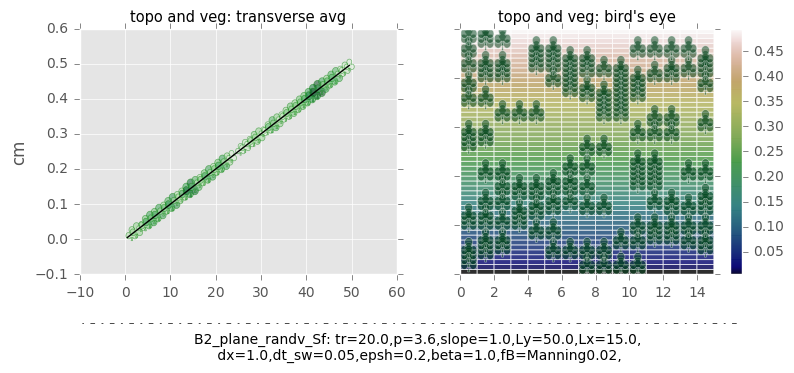

In [110]:
def plot_setup():
    import cmocean
    fig = plt.figure(figsize =(9, 4))
    gs = gridspec.GridSpec(5, 2)
    ax = plt.subplot(gs[0:4, 0])

    plt.plot(ycc[1, :], zcc[1, :],'k')
    vegplot = ax.scatter(ycc[1,:], zcc[1, :]+.001, s = isvegcc.mean(0)**.5*200, 
                    c=isvegcc.mean(0), cmap=cm.Greens,  marker=r'$\clubsuit$',
                   edgecolors='g', alpha = 0.5)
    plt.title('topo and veg: transverse avg', fontsize = 10.5)
    plt.ylabel('cm')
    
    ax = plt.subplot(gs[0:4, 1])   
    plt.title('topo and veg: bird\'s eye', fontsize = 10.5)
    plt.pcolor(zcc.T, cmap=cm.gist_earth, alpha= .8, edgecolors = 'w', linewidths=.6); 
    vegplot = ax.scatter(xcc/dx, ycc/dx, s = isvegcc*200, c=isvegcc,
                   cmap=cm.Greens,  marker=r'$\clubsuit$',
                   edgecolors='w', alpha=.5) 
    plt.ylim(0, nrow); plt.xlim(0, ncol)
    plt.colorbar(); 
    
    ttl = plt.suptitle(','.join([a for a in titlestr.split(',') if 'fV' not in a])
                       , fontsize = 10.); ttl.set_y(0.14)
    ax.annotate('', xy=(-1.5, -0.2), xycoords='axes fraction', xytext=(1.1, -0.2), 
                arrowprops=dict(arrowstyle="-", color='k', ls = '-.'))
    plt.setp(ax.get_yticklabels(), visible=False)
    fig = plt.gcf()
    fig.savefig('{0}/setup.pdf'.format(subfolder(), level))

plot_setup()

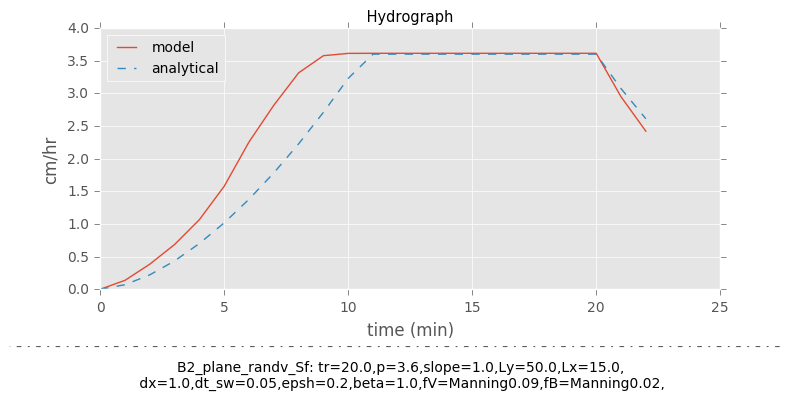

In [111]:
def hydrograph_compare(append = ''):
    """compare hydrograph to analytical solution from
      GW if coupled,  kinematic wave approx if uncoupled"""
    if slope > 0:
        fig = pretty_axes(titlestr)
        plt.plot(t_p/60., hydro_p*3.6e3, '-', label = 'model')
        if iscouple and tr >0:
            plt.plot(t_GW/60., q_GW*3.6e3, '--', label = 'GW')
        elif tr >0 :
            plt.plot(t_p/60., q0_p, '--', label = 'analytical')
        #plt.axhline(rain*3.6e5, ls = '-.', lw = .5, label = 'rain')
        plt.title(' Hydrograph {0}'.format(append), fontsize = 10.5)
        plt.xlabel('time (min)'); plt.ylabel('cm/hr')
        plt.legend(fontsize = 10, loc= 'best')
        fig.savefig('{0}/hydrograph{1}.pdf'.format(subfolder(), append))
hydrograph_compare('')

In [112]:
def vegplot():
    vegplot = plt.scatter(ycc[1,:], zcc[1, :]*.01, s = isvegcc.mean(0)**.5*200, 
            c=isvegcc.mean(0), cmap=cm.Greens,  marker=r'$\clubsuit$',
            edgecolors='g', alpha = 0.8)

def infiltration_compare(append = ''):
    if iscouple == 1 and case == 'SVE':

        fig = pretty_axes(titlestr)
        yy = np.arange(0, Ly, dx)
        plt.title('Cumulative infiltration {0}'.format(append), fontsize = 10.5)

        plt.plot(yy, zinflmap.mean(0), '-', label = '')               
        #plt.plot(yy, fluxin_map.sum(0)[1,:], '-', label = 'from Richard')
        vegplot()
        plt.xlabel('y (m)'); plt.ylabel('cm'); plt.xlim(0, Ly-dx)
        fig.savefig('{0}/infl_profile{1}.pdf'.format(subfolder(), append))

infiltration_compare(append)

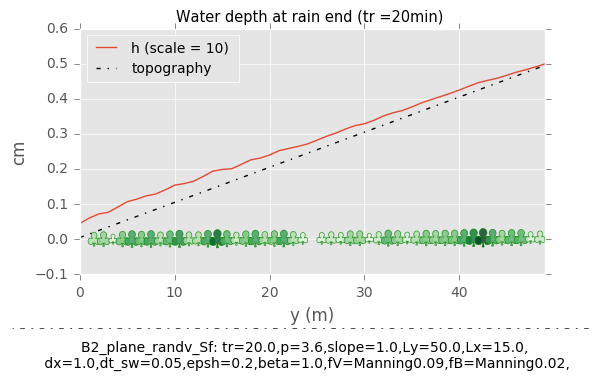

In [113]:
def vegplot():
    vegplot = plt.scatter(ycc[1,:], zcc[1, :]*.01, s = isvegcc.mean(0)**.5*200, 
            c=isvegcc.mean(0), cmap=cm.Greens,  marker=r'$\clubsuit$',
            edgecolors='g', alpha = 0.8)

def plot_h_tr(append = ''):
    if case == 'SVE':
        eqlind = np.where(t_p < tr)[0][-1]
        scalefactor = 10# get_scalefactor(zcc, h[eqlind])
        fig = pretty_axes(titlestr, figsize= (6,4))
        yy = np.arange(0, Ly, dx); plt.xlim(0, Ly-dx)
        plt.title('Water depth at rain end (tr ={0:.0f}min) '.format(tr/60.),fontsize = 10.5)
        
        if dim == 1 or level[0] =='A':
            plt.plot(yy, (zcc + h[eqlind]*scalefactor)[1, :], '-', 
                     label = 'h (scale = {0:.0f}) '.format(scalefactor))
            plt.plot(yy, zcc[1, :], 'k-.', label = 'topography')
            plt.plot(yy[[isvegcc[1]> 0]],zcc[1, isvegcc[1]> 0], 'gd',label = 'veg')   

        else:
            plt.plot(yy, (zcc[1, :] + h[eqlind].mean(0)*scalefactor), '-',
                     label = 'h (scale = {0:.0f}) '.format(scalefactor))
            plt.plot(yy, zcc[1, :], 'k-.', label = 'topography')
            vegplot()

        plt.xlabel('y (m)'); plt.ylabel('cm')
        plt.legend(fontsize = 10, loc= 'best')
        fig.savefig('{0}/h(tr){1}.pdf'.format(subfolder(), append))

plot_h_tr(append) 

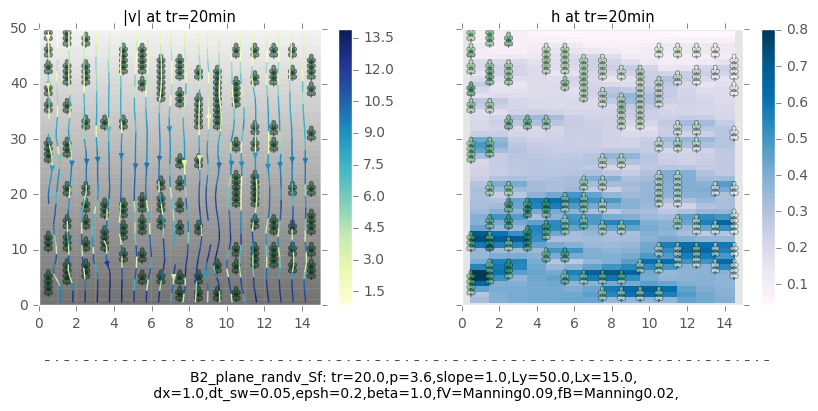

In [118]:
vmag = (u**2 +  v**2)**.5 

if dim == 2:

    fig, ax = plt.subplots(figsize =(10, 4.5))
    ttl = plt.suptitle(titlestr, fontsize = 10.); ttl.set_y(0.14)
    gs = gridspec.GridSpec(5, 2)

    ax = plt.subplot(gs[0:4, 0])
    #plt.pcolor(vmag[eqlind].T*100, cmap=cm.YlGnBu, alpha= 1); 
    plt.pcolor(zcc.T, cmap=cm.gist_gray, alpha= .5, edgecolors = 'w', 
               linewidths=0); 
    
    vegplot = ax.scatter(xcc/dx, ycc/dx, s = isvegcc*50, c=isvegcc,
                   cmap=cm.Greens,  marker=r'$\clubsuit$',
                   edgecolors='k', alpha=.5) 
    strm = ax.streamplot( xcc.T, ycc.T, u[eqlind].T, v[eqlind].T, 
                         color=vmag[eqlind].T*100, linewidth=1,
                         cmap=cm.YlGnBu, density = .8)
    fig.colorbar(strm.lines)    
    #plt.quiver(xcc, ycc, u[eqlind], v[eqlind],
    #          np.abs(vmag[eqlind])*1e4,
    #          cmap=cm.YlGnBu)


    plt.ylim(0, nrow); plt.xlim(0, ncol)
    
    plt.title('|v| at tr={0:.0f}min'.format(tr/60.), fontsize = 10.5) 

    ax = plt.subplot(gs[0:4, 1])

    plt.pcolormesh(xcc.T/dx, ycc.T/dx, (h[eqlind].T)*100, cmap=cm.PuBu, alpha= 1); 
    plt.colorbar()
    vegplot = ax.scatter(xcc/dx, ycc/dx, s = isvegcc*50, c=h[eqlind].T,
                cmap=cm.Greens,  marker=r'$\clubsuit$',
                edgecolors='k', alpha=.5) 

    ax.annotate('', xy=(-1.5, -0.2), xycoords='axes fraction', xytext=(1.1, -0.2), 
                arrowprops=dict(arrowstyle="-", color='k', ls = '-.'))
    plt.setp(ax.get_yticklabels(), visible=False)
        
    plt.ylim(0, nrow); plt.xlim(0, ncol)
    plt.title('h at tr={0:.0f}min'.format(tr/60.), fontsize = 10.5) 


In [119]:
def plot_zinflmap(append):
    if iscouple == 1:
        fig = plt.figure(figsize =(9, 4))
        gs = gridspec.GridSpec(5, 2)
        ax = plt.subplot(gs[0:4, 0])
        
        if slope > 0:
            plt.pcolor(zcc.T, cmap=cm.gist_earth, alpha= .7); 
            vegplot = ax.scatter(xcc/dx, ycc/dx, s = isvegcc*100, c=isvegcc,
                   cmap=cm.Greens,  marker=r'$\clubsuit$',
                   edgecolors='w', alpha=.5) 
            plt.ylim(0, nrow); plt.xlim(0, ncol)                 
            plt.title('Topo (color) and veg (o)', fontsize = 10.5)
            plt.colorbar(); 
        elif case == 'richards':
            plt.plot(ycc[1, :], zcc[1, :],'k')
            vegplot = ax.scatter(ycc[1,:]/dx, xcc[1,:]/dx*0, s = isvegcc[1,:]*200, c=isvegcc[1,:],
                   cmap=cm.Greens,  marker=r'$\clubsuit$',
                   edgecolors='w', alpha=.5)
            ax.scatter(ycc[1, :] , zinflmap[1, :], 
                       s = zinflmap[1]**.7*50, marker = 'd', 
                       c= zinflmap[1], cmap = cmocean.cm.ice, edgecolors= 'k')
            #   plt.xlim(0+dx, nrow-dx/2.) 
            plt.title('infiltration depth', fontsize = 10.5)
            plt.ylabel('cm')

        ax = plt.subplot(gs[0:4, 1])

        plt.pcolor(zinflmap.T , cmap=cm.Blues, alpha= 1); 
        vegplot = ax.scatter(xcc/dx, ycc/dx, s = isvegcc*100, c=isvegcc,
                   cmap=cm.Greens, marker=r'$\clubsuit$',
                   edgecolors='w', alpha=.5, label = 'veg')

        plt.ylim(0, nrow); plt.xlim(0, ncol)            
        plt.title('Inflmap (cm)'.format(append), fontsize = 10.5) 
        plt.colorbar() 
        ttl = plt.suptitle(titlestr, fontsize = 10.); ttl.set_y(0.14)
        ax.annotate('', xy=(-1.5, -0.2), xycoords='axes fraction', xytext=(1.1, -0.2), 
                    arrowprops=dict(arrowstyle="-", color='k', ls = '-.'))
        plt.setp(ax.get_yticklabels(), visible=False)
        fig.savefig('{0}/zinflmap{1}.pdf'.format(subfolder(), append))

plot_zinflmap(append) 

### Part Weed: Friction Weeds

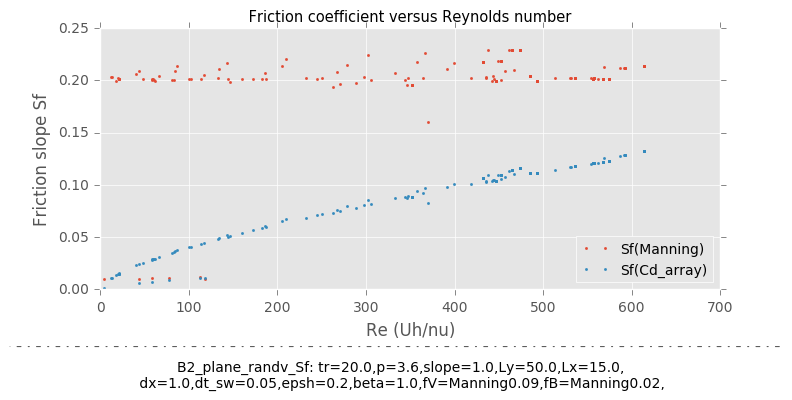

In [120]:

def plot_Sf(append=''):
    if case == 'SVE':
        fig = pretty_axes(titlestr)
        yy = np.arange(0, Ly, dx)
        plt.title(' Friction coefficient versus Reynolds number {0}'.format(
                append), fontsize = 10.5)

        vdum = -v[v<-.0][::100]
        hdum = h[v<-.0][::100]
        Re = vdum*hdum/1e-6

        Sf_manning = vdum**2./hdum**(4./3)*xnv**2
        plt.plot(Re, Sf_manning, '.',ms = 3, label = 'Sf(Manning)')

        Rv = Dveg*(1-pveg)/pveg*np.pi/4
        Rev = vdum*Rv/1e-6
        Cdarray = 50*Rev**(-0.43) + 0.7*(1-np.exp(-Rev/15000.))
        m = 4*pveg/np.pi/Dveg**2
        Sf_array = Cdarray*m*Dveg/(1-pveg)*vdum**2/2/9.8
        plt.plot(Re, Sf_array, '.', ms = 3, label = 'Sf(Cd_array)')
        plt.legend(fontsize = 10, loc= 'best')
        plt.xlabel('Re (Uh/nu)'); plt.ylabel('Friction slope Sf')
        #plt.ylim(np.min([Sf_array, Sf_manning]), np.max([Sf_array,Sf_manning*2]))
        fig.savefig('{0}/weeds/Sf{1}.pdf'.format(folder, append))

        
plot_Sf(append) 

### Part Weed: hydrograph weeds

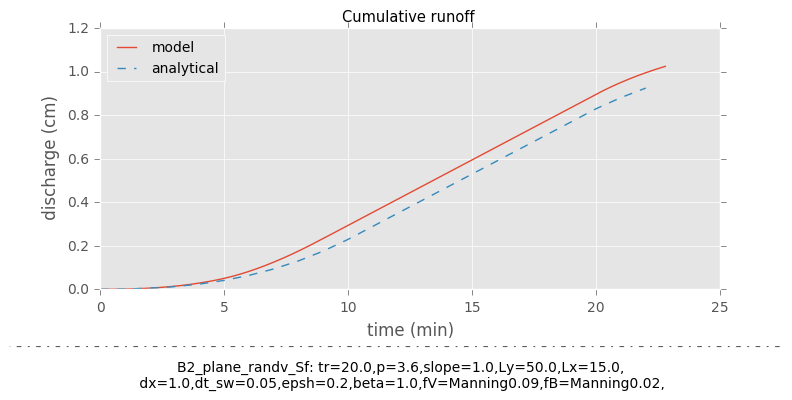

In [121]:
# cumulative hydrograph
dt_p = t_p[1]- t_p[0]
if slope > 0:
    ylabel = ' [cm/hr]'
    fig = pretty_axes(titlestr)
    plt.plot(t_sw/60., np.cumsum(flux1/Lx/Ly*100), label = 'model') #  in cm
    #plt.plot(t_p/60., np.cumsum(hydro_p*dt_p), '--')
    if iscouple and tr >0:
        dt_GW = np.diff(np.hstack((0, t_GW)))
        plt.plot(t_GW/60., np.cumsum(q_GW*dt_GW), '-', label = 'GW')
    elif tr >0 :
        plt.plot(t_p/60., np.cumsum(q0_p/3.6e3*dt_p), '--', label = 'analytical')
        
    # plt.axhline(rain*3.6e5, ls = '-.', lw = .5, label = 'rain')
    plt.title('Cumulative runoff {0}'.format( append), fontsize = 10.5)

    plt.xlabel('time (min)'); plt.ylabel(' discharge (cm)')
    plt.legend(fontsize = 10, loc= 'best')
    fig.savefig('{0}/weeds/cumulative_runoff{1}.pdf'.format(folder,append))
 


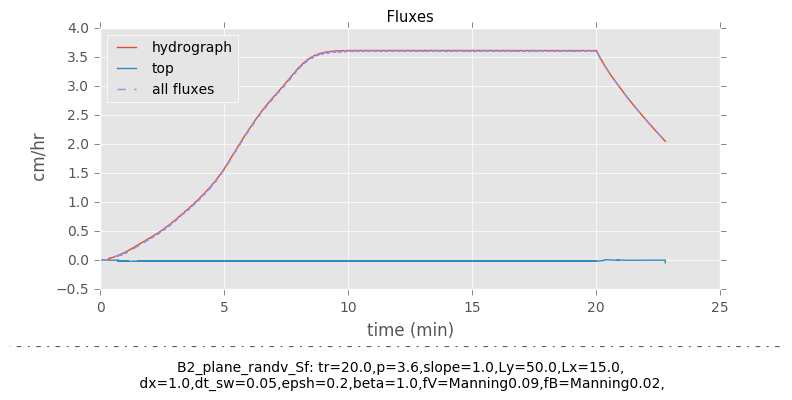

In [122]:
if slope> 0:

    binfreq = 1
    # convert m3 to cm/hr
    f1 = mybin(flux1, binfreq)/dt_sw/Ly/Lx*3.6e5
    f3 = mybin(flux3, binfreq)/dt_sw/Ly/Lx*3.6e5
    tdum = mybin(t_sw, binfreq)
    t0 = int(np.where(tdum>0)[0][0])
    t1 = int(np.where(tdum<=tmax)[0][-1])

    fig = pretty_axes(titlestr)

    # if iscouple == 1 and tr >0:
    #     plt.plot(t_GW/60., q_GW*3600., '-', label = 'GW')
    # elif tr >0:
    #     plt.plot(t_p[t0:]/60., q0_p[t0:], '-.', lw = 1.4, label = 'analytical')

    plt.plot(tdum[t0:t1]/60., f1[t0:t1], '-', ms = 1, label = 'hydrograph')
    plt.plot(tdum[t0:t1]/60., f3[t0:t1], '-', label = 'top')
    plt.plot(tdum[t0:t1]/60., (f3+f1)[t0:t1], '--', ms = 1, label = 'all fluxes')
    plt.title(' Fluxes {0}'.format( append), fontsize = 10.5)
    plt.xlabel('time (min)'); plt.ylabel(' {0}'.format('cm/hr'))
    plt.legend(fontsize = 10, loc= 'best')
    fig.savefig('{0}/weeds/fluxes{1}.pdf'.format(folder,append))

### Part WI:  Infiltration Weeds

In [75]:
weeds = 1
if weeds == 1 and iscouple == 1:
    fig = pretty_axes(titlestr)
    plt.title('Cumulative fluxes paritioning', size = 10.5)
    plt.plot(t_sw, np.cumsum(rain_sw), '--', label = 'precip')
    plt.plot(t_sw, -np.cumsum(flux), '-', label = 'lateral fluxes')
    plt.plot(t_sw, -np.cumsum(zinfl), '-', label = 'infl')
    plt.plot(t[:len(fluxin_for)], np.cumsum(error_for2), '-.', label = 'richards err') 
        
    plt.xlabel('time (s)'); plt.ylabel('cm')
    #plt.plot(t_GW, np.cumsum(q_GW*dt_GW), '-', label = 'GW')
    plt.legend(loc = 'best', fontsize =10.5)
    fig.savefig('{0}/weeds/infl_cumulative.pdf'.format(folder))

    fig = pretty_axes(titlestr)
    plt.title('Infiltration rate from Richards vs. SVE ', size = 10.5)
    plt.plot(t_sw, -zinfl/dt_sw, '--', label = 'from SVE')
    plt.plot(t[:len(fluxin_for)], fluxin_for/dt, '-', ms = 1, label = 'from Richard')
    plt.xlabel('y (m)'); plt.ylabel('cm/s')
    plt.legend(loc = 'best', fontsize =10.5)
    fig.savefig('{0}/weeds/infl_comparison{1}.pdf'.format(folder,append))


In [76]:
if weeds == 1 and iscouple == 1:
    #  cumulative error
    fig = pretty_axes(titlestr)
    append = '({0})'.format(fVstr(ifricV))
    plt.title('Infiltration: cumulative mass error {0}'.format(append), fontsize = 10)
    # plt.plot(t, np.cumsum(fluxin - newmass + fluxout ), '-', label =  'uncorrected')
    # plt.plot(t, np.cumsum(fluxin - newmass + fluxout - error), '-', label =  'corrected')
    tdum = t[:len(fluxin_for)]
    plt.plot(tdum[1:], np.cumsum((fluxin_for - newmass_for  + fluxout_for)[1:] ), '-', label =  'uncorrected')
    plt.plot(tdum[1:], np.cumsum(fluxin_for - newmass_for + fluxout_for - error_for)[1:], '-', label =  'corrected')
    plt.plot(tdum, np.cumsum(error_for), '-', label =  'estimated')

    plt.xlabel('time (s)'); plt.ylabel('cm')
    plt.legend(loc = 'best', fontsize = 10)
    fig.savefig('{0}/weeds/richards_errors{1}.pdf'.format(folder, append))
    
if weeds == 1 and iscouple == 1:
    scale = 3600./dt
    ylabel = 'cm/hr'
    append = '({0})'.format(fVstr(ifricV))
    fig = pretty_axes(titlestr)
    plt.title('Mass balance components {0}'.format(append), fontsize = 11)
    plt.plot(tdum, fluxout_for*scale, label = 'flux out')
    plt.plot(tdum, fluxin_for*scale, '-', ms = 1, label = 'flux in')
    plt.plot(tdum, error_for*scale, '-',  label = 'error')
    plt.plot(tdum[1:], newmass_for[1:]*scale, '-.', lw = 1, label = 'mass change')
    plt.legend(loc = 'best', fontsize = 10)
    plt.xlabel('time [s]') 
    plt.ylabel('cm/hr')

    fig.savefig('{0}/weeds/richards_fluxes{1}.pdf'.format(folder, append))

## Part M: Multirun comparison
### Read summary file for summary stats


In [77]:
level = 'B2i_plane_randv_Sf';
# init_params(level = level, nrow = 40, ncol = 10, dt_sw = .05, 
#             tr = 20*60., tmax = 100*60., rain = .036/3600., ifricV = 3,         
#             slope = 0.01)

In [78]:
# multirun comparisons
def read_summaryC(filename):
    datafile = 'outputs/Csummaries/{1}'.format( folder, filename)
    g = open(datafile, 'r')
    data = []
    index = []
    for line in g:
        a = (line.strip().split(" "))
        data.append(float(a[-1]))
        index.append(a[0])
    return data, index

files = os.listdir("outputs/Csummaries".format(folder))
if '.DS_Store' in files: files.remove('.DS_Store')


In [79]:
def read_titlstr(filename, data = [], index = [], rowname = []):
      
    for var in dumfile.split(','):

        try:
            data.append(float(var.split('=')[1]))
        except ValueError:
            data.append((var.split('=')[1]))
        except IndexError:
            continue
        index.append(var.split('=')[0])

        if var.split('=')[0] in titlevar:
            rowname.append(var)

    index.append('titlestr')
    dumtitle =  '\n dx'.join(([a for a in dumfile[:-4].split('dx')]))
    dumtitle =  '\n isc'.join(([a for a in dumtitle.split('isc')]))
    data.append(dumtitle)
    index.append('level')
    data.append(dumfile.split(',')[0])    
    myseries =  pd.Series(data, index = index, name = ','.join(rowname))
    
    return myseries

In [80]:
def df_filter(df, fld1 = "Ly", val1 = 20, fld2 = 'dt_sw', val2 = 0.05 ):
    df = df[df[fld1] == val1]
    if fld2:
        df = df[df[fld2] == val2]
    return df

pd.set_option('display.float_format', lambda x: '%.3f' % x)
#pd.reset_option('^display.', silent=True)


In [81]:
## read summary files
# VOI = [ 'iscale', 'dt_sw', 'tr', 'Ly', 'dt', 'fV', 'slope']
df_sum = pd.DataFrame()
titlevar = ['fV', 'slope']
for dumfile in files:   
    data, index = read_summaryC(dumfile)
    myseries = read_titlstr(dumfile, data = data, index = index, rowname = [])
    df_sum = df_sum.append(myseries)

    
# df_sum = df_filter(df_sum )    


In [82]:
# df_sum = df_sum[df_sum.Ly == 20]
cols  = ['veg_infl_percent', 'veg_area', 'ReMax', 'hmax', 'hydro_peak', 'time2peak90', 'infl_percent']
cols = [col for col in df_sum.columns if col in cols]

In [83]:
def read_from_pkl(hfile, datastr):
    import cPickle as pickle
    fname = 'outputs/main/{1}'.format(folder, datastr)
    result = pickle.load( open( fname, "rb" ) )
    return pd.Series(result, name = datastr)

In [84]:
outfiles = os.listdir("outputs/main/".format(folder))
if '.DS_Store' in outfiles: outfiles.remove('.DS_Store')
    
dfs = pd.DataFrame()
data = []
index = []
result = []
for dumfile in outfiles:
    myseries = []
    result = read_from_pkl(folder, dumfile)
    
    myseries = read_titlstr(dumfile, data = [], index = [], rowname = [])
    print dumfile, myseries.level
    #result = pd.concat([myseries, result], axis = 0)
    #result.name = myseries.name
    for key in myseries.keys():
        #if key not in dfs.columns:       
        result.set_value(key, myseries[key])
    dfs = dfs.append(result, ignore_index=  True)

B2_plane_randv_Sf,tr=20.0,p=3.6,slope=1.0,Ly=50.0,Lx=10.0,dx=1.0,dt_sw=0.05,epsh=0.2,beta=1.0,fV=Manning0.09,fB=Manning0.02,.pkl B2_plane_randv_Sf
B2_plane_randv_Sf,tr=20.0,p=3.6,slope=1.0,Ly=50.0,Lx=20.0,dx=1.0,dt_sw=0.05,epsh=0.2,beta=1.0,fV=Manning0.09,fB=Manning0.02,.pkl B2_plane_randv_Sf


In [85]:
# for key in dfs.columns:
#     try:
#         print key, ': size = ', np.size(dfs.iloc[0][key])
#     except AttributeError:
#         print key

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


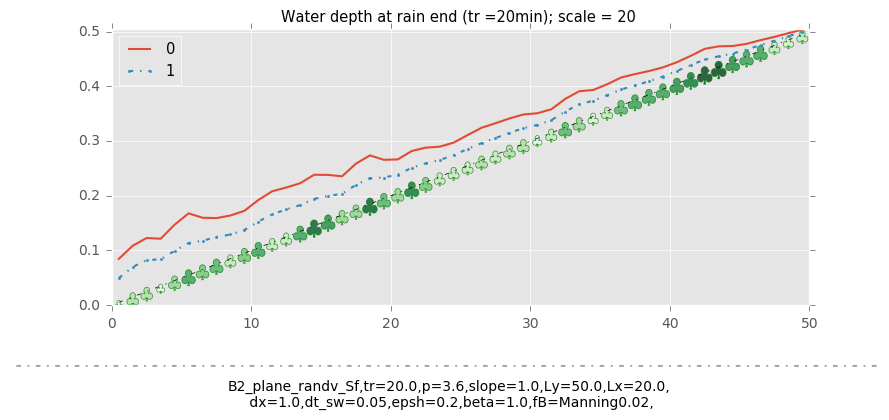

In [86]:
lstyles = ['-', '.-.', '--', 'd']
scalefactors = []
for i,index in enumerate(dfs.index):
    df = dfs.loc[index]
    scalefactors.append(get_scalefactor(df.zcc, df.h))

scalefactor = max(scalefactors)   

fig = pretty_axes(','.join([a for a in df.titlestr.split(',') if 'fV' not in a]),
                  figsize = (9, 4.5))
for i,index in enumerate(dfs.index):
    df = dfs.loc[index]
    h_tr = df.h[df.eqlind]
    plt.plot(df.ycc.mean(0), (df.zcc + h_tr*scalefactor).mean(0),
             lstyles[i], ms = 3, label = index, alpha =1, linewidth = 1.5)
plt.plot(df.ycc.mean(0), df.zcc.mean(0), 'k-.', lw = .5, label = '')
plt.legend(loc = 'best', fontsize = 10.5)
vegplot = plt.scatter(df.ycc[1,:], df.zcc[1, :]-.005, s = df.isvegcc.mean(0)**.5*200, 
            c=df.isvegcc.mean(0), cmap=cm.Greens,  marker=r'$\clubsuit$',
            edgecolors='g', alpha = 0.8)
plt.xlim(0, np.max(df.ycc)+.5); plt.ylim(0, np.max(df.zcc + df.h+.01))
plt.title('Water depth at rain end (tr ={0:.0f}min); scale = {1:.0f} '.format(
        tr/60., scalefactor),fontsize = 10.5)


In [87]:
dfs['level']

0    B2_plane_randv_Sf
1    B2_plane_randv_Sf
Name: level, dtype: object

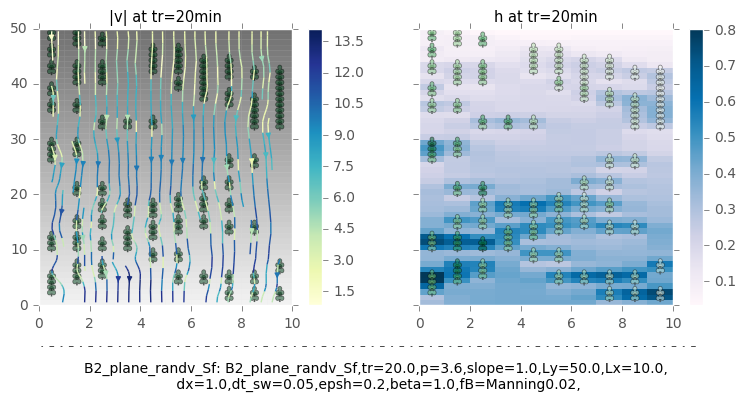

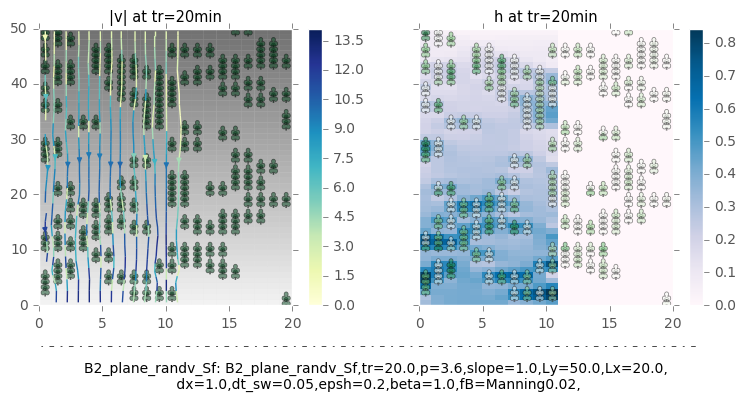

In [88]:
for i,index in enumerate(dfs.index):
    

    df = dfs.loc[index]
   
    vmag = np.sqrt(df.u_tr**2 + df.v_tr**2)
    nrowdum = df.xcc.shape[1]; ncoldum = df.xcc.shape[0]

    fig, ax = plt.subplots(figsize =(9, 4.5))
    
    looptitle = ','.join([a for a in df.titlestr.split(',') if 'fV' not in a])
    looptitle = df.level + ': ' + looptitle
    ttl = plt.suptitle(looptitle, fontsize = 10.); ttl.set_y(0.16)
    
    gs = gridspec.GridSpec(5, 2)

    ax = plt.subplot(gs[0:4, 0])
    #plt.pcolor(vmag[eqlind].T*100, cmap=cm.YlGnBu, alpha= 1); 
    plt.pcolor(df.zcc.T, cmap=cm.gist_gray_r, alpha= .5, edgecolors = 'w', 
               linewidths=0); 

    vegplot = ax.scatter(df.xcc/dx, df.ycc/dx, s = df.isvegcc*50, c=df.isvegcc,
                   cmap=cm.Greens,  marker=r'$\clubsuit$',
                   edgecolors='k', alpha=.5) 
    strm = ax.streamplot( df.xcc.T, df.ycc.T, df.u_tr.T, df.v_tr.T, 
                         color=vmag.T *100, linewidth=1,
                         cmap=cm.YlGnBu, density = .8)
    fig.colorbar(strm.lines)

    plt.ylim(0, nrowdum); plt.xlim(0, ncoldum)
    plt.title('|v| at tr={0:.0f}min'.format(tr/60.), fontsize = 10.5) 

    ax = plt.subplot(gs[0:4, 1])

    plt.pcolormesh((df.h_tr.T)*100, cmap=cm.PuBu, alpha= 1); 
    plt.colorbar()
    vegplot = ax.scatter(df.xcc/dx, df.ycc/dx, s = df.isvegcc*50, c=df.h_tr.T,
                cmap=cm.Greens,  marker=r'$\clubsuit$',
                edgecolors='k', alpha=.5) 
    ax.annotate('', xy=(-1.5, -0.15), xycoords='axes fraction', xytext=(1.1, -0.15), 
                arrowprops=dict(arrowstyle="-", color='k', ls = '-.'))
    plt.setp(ax.get_yticklabels(), visible=False)
    
    plt.ylim(0, nrowdum); plt.xlim(0, ncoldum)
    plt.title('h at tr={0:.0f}min'.format(tr/60.), fontsize = 10.5) 


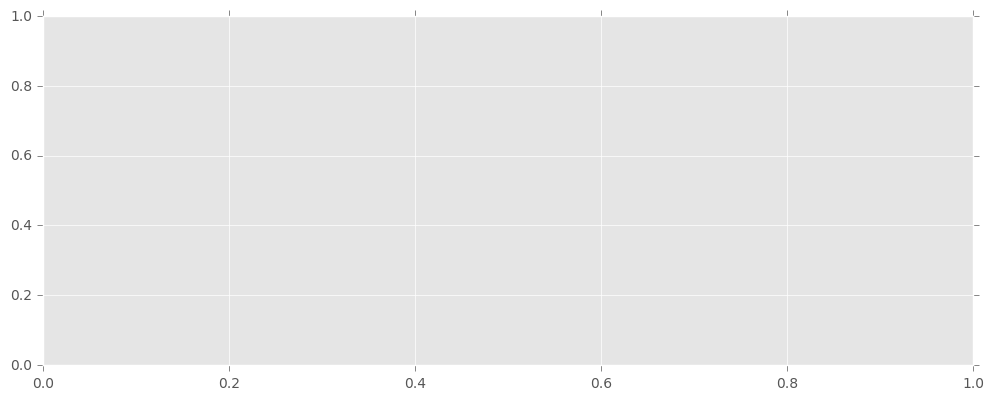

In [89]:
fig, ax = plt.subplots(figsize =(12, 4.5))    

dfsplot = dfs[dfs.iscouple == 1]
for i,index in enumerate(dfsplot.index): 
    df = dfsplot.loc[index]
    nrowdum = df.xcc.shape[1]; ncoldum = df.xcc.shape[0]
    
    looptitle = ','.join([a for a in df.titlestr.split(',') if 'fV' not in a])
    ttl = plt.suptitle(looptitle, fontsize = 10.); ttl.set_y(0.16)

    gs = gridspec.GridSpec(5, len(dfsplot))
    ax = plt.subplot(gs[0:4, i])
    
    plt.pcolor(df.zinflmap.T, cmap=cm.Blues, alpha= 1); 
    plt.colorbar()
    vegplot = ax.scatter(df.xcc/dx, df.ycc/dx, s = df.isvegcc*50, c=df.isvegcc,
                cmap=cm.Greens,  marker=r'$\clubsuit$',
                edgecolors='k', alpha=.5) 
    #ax.annotate('', xy=(-1.5, -0.15), xycoords='axes fraction', xytext=(1.1, -0.15), 
    #            arrowprops=dict(arrowstyle="-", color='k', ls = '-.'))
    plt.setp(ax.get_yticklabels(), visible=False)
    
    plt.ylim(0, nrowdum); plt.xlim(0, ncoldum)
    plt.title(index , fontsize = 10.5) 


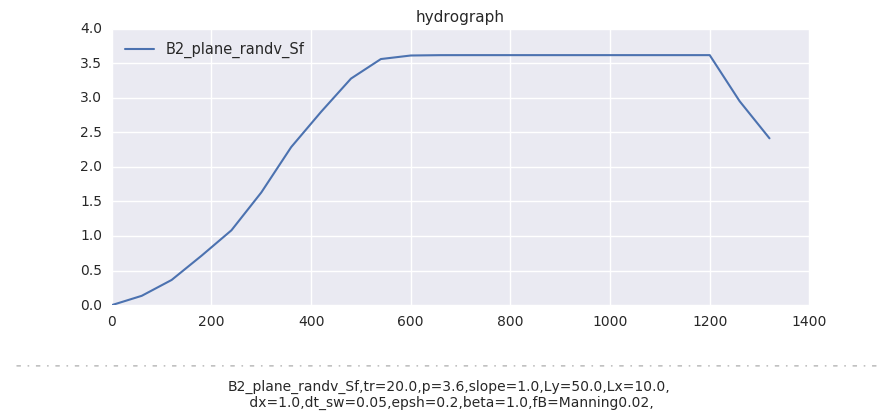

In [741]:
fig = pretty_axes(','.join([a for a in df.titlestr.split(',') if 'fV' not in a]),
                  figsize = (9, 4.5))
lstyles = ['-', '.-.', '--', 'd']
dfsplot = dfs[dfs.iscouple == 0]
for i,index in enumerate(dfsplot.index):
    df = dfs.loc[index]
    plt.plot(dfs.loc[index].t_p, dfs.loc[index].hydro_p*3.6e3,
             lstyles[i], ms = 3, label = df.level, alpha =1, linewidth = 1.5)
plt.legend(loc = 'best', fontsize = 10.5)
plt.title('hydrograph', fontsize = 11)

In [739]:
dfp

,Lx,Ly,Remax,beta,dt_sw,dx,epsh,fB,fV,hmax,...,iscale,ksatB,ksatV,richards_err,richards_infl,stop_tol,t_final,veg_area,veg_infl_percent,zmax
"slope=0.0,fV=Manning0.09",nan,2.000,10.426,1.000,0.050,1.000,0.200,Manning0.02,Manning0.09,0.350,...,100.000,0.200,3.000,0.023,1.170,0.010,1820.500,0.500,0.861,20.0.txt


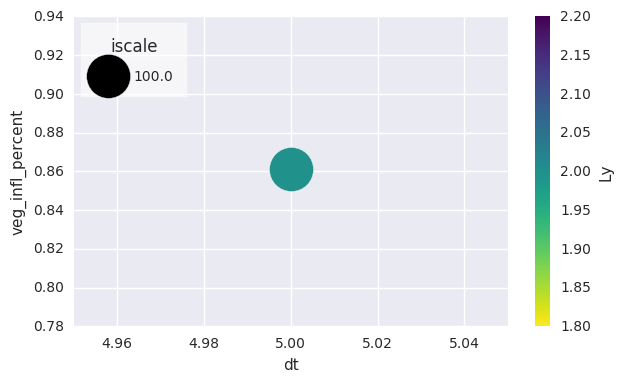

In [409]:
if case == 'richards':
    plt.figure(figsize = (7,4))
    dfp = df_sum[df_sum.iscale > 0]
    # dfp = dfp[dfp.Ly == 4]
    import seaborn as sns

    plt.scatter(dfp.dt_sw*dfp.iscale, dfp.veg_infl_percent, 
                c = dfp.Ly, s=(dfp.iscale**.5)*100, cmap="viridis_r")
    ax = plt.gca()
    plt.colorbar(label="Ly")
    plt.xlabel("dt")
    plt.ylabel("veg_infl_percent")


    pws = np.unique(dfp.iscale)
    for pw in pws:
        plt.scatter([], [], s=(pw**.5)*100, c="k",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    legend = plt.legend(h[1:], l[1:], labelspacing=1., title="iscale", borderpad=1, 
                frameon=True, framealpha=0.6,loc = 'upper left')
    legend.get_frame().set_facecolor('w')


In [410]:
def scatter_richards(dfp):
    fig = plt.figure(figsize = (7,4))
    plt.scatter(dfp.xnv, dfp.veg_infl_percent, 
                c = dfp.Ly, s=(dfp.dt_sw**.6)*200, cmap="viridis_r")
    ax = plt.gca()

    plt.colorbar(label="Ly")
    plt.xlabel("xnv")
    plt.ylabel("veg_infl_percent")

    #make a legend:
    pws = np.unique(dfp.dt_sw)
    for pw in pws:
        plt.scatter([], [], s=(pw**.75)*200, c="k",label=str(pw))

    h, l = plt.gca().get_legend_handles_labels()
    legend = plt.legend(h[1:], l[1:], labelspacing=1., title="dt_sw", borderpad=1, 
                frameon=True, framealpha=0.6,loc = 'upper left')
    legend.get_frame().set_facecolor('w')

if case == 'richards':
    dfp = df[df['xnv'] >0]
    dfp = dfp[dfp.tr == 10]

    scatter_richards(dfp)

KeyError: 'xnv'

### SVE Animations

In [252]:
if case == 'SVE':
    anim = 1
else:
    anim = 0
    
anim = 1

In [ ]:
col = 1 
yy = np.arange(0, nrow*dx, dx)
if dim == 1 and tr > 0:
    fig = pretty_axes(titlestr, figsize = (6,4.))
    zmin =  np.unique(h)[0] - 0.001
    zmax = np.unique(h)[-1] + 0.001
    eqlind = np.where(t_p < tr)[0][-1]
    #ax = plt.axes(xlim=(np.min(yy), np.max(yy)), ylim=(zmin, zmax))
    img, = plt.plot(yy[:],  h[eqlind][col, :], label = 'h')
    img, = plt.plot(yy[:],  -v[eqlind][col, :], label = 'v')
    #img, = plt.plot(yy[:],  h[eqlind+25][col, :], '--', label = 't={0:.1f}min'.format(t_p[eqlind+25]/60.))
    #img, = plt.plot(yy[:],  h[eqlind+50][col, :], '-.', label = 't={0:.1f}min'.format(t_p[eqlind+50]/60.))

    plt.title('h after rain (t={0:.1f}min)'.format(t_p[eqlind]/60.),animated=True, fontsize = 10.5)
    plt.legend(loc=  'best', fontsize = 10)
    plt.xlabel('x (m)');plt.ylabel('h (m)')
    


In [ ]:
vegind = np.where(isvegcc[col, :]>0)[0]
nvegind = np.where(isvegcc[col, :]>=0)[0]    
    
if dim == 1:
    hplot = h[::10, :,:]
    fig=pretty_axes(titlestr)
    yy = np.arange(0, nrow*dx, dx);  
    col = ncol/2

    zmin =  np.unique(hplot[:,:,:]+zc)[1] - 0.001
    zmax = np.unique(hplot[:,:,:]+zc)[-1] + 0.001

    ax1 = plt.axes(xlim=(0-.5, np.max(yy)), ylim=(zmin, zmax))
    ax1.plot(yy,  (zc + h[eqlind])[col], 'b')
    ax1.set_ylabel('h(m)', color='b')
    ax1.tick_params('y', colors='b')

    ax2 = ax1.twinx()
    ax2.plot(yy[:],  -v[eqlind][col, :], 'g-.', 
             label = 'v')
    
    ax2.set_ylabel('v (m/s)', color='g')
    ax2.tick_params('y', colors='g')


    plt.setp( ax2.get_xticklabels(), visible=False)
    plt.setp( ax1.get_xticklabels(), visible=False)
    plt.setp(ax2.get_ygridlines(), visible = False)
    if len(nvegind) >0:
        plt.plot(yy[nvegind], zc[col, nvegind], 'k--', lw = .5, label =
                 'bare; n={0}'.format(xni))
    if len(vegind) > 0:
        plt.plot(yy[vegind],  zc[col, vegind], 'gd', lw = 1., label =
                 'veg; n={0}'.format(xnv)) 

    plt.legend(fontsize = 11, loc = 'lower right')

    plt.xlim(np.min(yy)-.1, np.max(yy)+.1)

In [ ]:
if itype3 > 1:
    fig = pretty_axes(titlestr)
    yy = np.arange(0, nrow*dx, dx)
    for i in np.arange(len(h)/2, len(h)+1, len(h)/8, dtype = int)[1:]+2:
        img, = plt.plot(yy[:],  h[i][col, :], label = 't={0:.0f}min'.format(t_p[i]/60.))

    ttl = ax.set_title('h profile'.format(0),animated=True, fontsize = 10.5)
    plt.legend(loc=  'best', fontsize = 10)
    plt.xlabel('x (m)'); plt.ylabel('h (m)')


In [ ]:
fig = pretty_axes(titlestr)
yy = np.arange(0, nrow*dx, dx);
col = ncol/2


plt.title('Model set up ({0})'.format(level), fontsize = 11)

if len(nvegind) >0:
    plt.plot(yy[nvegind], zc[col, nvegind], 'k--', lw = .5, label = 'bare; n={0}'.format(xni))
if len(vegind) > 0:
    plt.plot(yy[vegind]+.01,  zc[col, vegind], 'gd', lw = 1., label = 'veg; n={0}'.format(xnv)) 

plt.legend(fontsize = 11, loc = 'lower right')
fig.savefig('{0}/single/setup_profile.pdf'.format(folder, append))

In [ ]:
hplot = (h[::10,:, :])
if anim:
    append = '({0})'.format(fVstr())
    fig= pretty_axes((titlestr))
    zmin =  np.unique(h)[1] - 0.001
    zmax = np.unique(h)[-1] + 0.001
    x0 = 0
    ax = plt.axes(xlim=(yy[x0], yy[-1]), ylim=(zmin, zmax))
    img, = plt.plot(yy[x0:],  h[1][col, x0:], 'b-')
    ttl = ax.set_title('',animated=True, fontsize = 11); ttl.set_y(.95)
    
    plt.setp( ax.get_xticklabels(), visible=False)
    col = ncol/2  
    if len(nvegind) >0:
        plt.plot(yy[nvegind], zc[col, nvegind]*0, 'k--', lw = .5, label = 'bare; n={0}'.format(xni))
    if len(vegind) > 0:
        plt.plot(yy[vegind],  zc[col, vegind]*0, 'gd', lw = 1., label = 'veg; n={0}'.format(xnv)) 
  
    plt.legend(fontsize = 11, loc = 'upper right')
    plt.ylabel('h (m)')
    def init():
        ttl.set_text(1) 
        img.set_data([0],[0])
        return img, ttl, ax.xaxis

    def func(n):
        ttl.set_text('height; t={0:.1f}min \n'.format( t_p[n]/60.*10))    
        img.set_data(yy[x0:], (hplot[n])[col, x0:] )
        ax.set_xlim(yy[x0],yy[-1])
    
        return img, ttl, ax.xaxis

    ani = animation.FuncAnimation(fig,func,init_func=init,frames=len(hplot),
                                   interval=100,blit=True)

    ani.save('{0}/single/h_anim{1}.mp4'.format(folder, append))


In [ ]:
scalefactor = 2
hplot = (h[::10,:, :])*scalefactor

if anim:
    append = '({0})'.format(fVstr())
    fig=pretty_axes(titlestr)
    yy = np.arange(0, nrow*dx, dx);  
    col = ncol/2
    zmin =  np.unique(hplot[:,:,:]+zc)[1] - 0.001
    zmax = np.unique(hplot[:,:,:]+zc)[-1] + 0.001

    ax = plt.axes(xlim=(0, yy[-1]+.1), ylim=(zmin, zmax))
    #plt.plot(yy[:],  zc[col, :], 'g-', label = 'n$_f$={0}'.format(xni))
    img, = plt.plot(yy,  (zc + h[1])[col], 'b')
    ttl = ax.set_title('',animated=True, fontsize = 11); ttl.set_y(.95)

    plt.ylabel('h (m)')
    plt.setp( ax.get_xticklabels(), visible=False)
        
    if len(nvegind) >0:
        plt.plot(yy[nvegind], zc[col, nvegind], 'k--', lw = .5, label =
                 'bare; n={0}'.format(xni))
    if len(vegind) > 0:
        plt.plot(yy[vegind],  zc[col, vegind], 'gd', lw = 1., label =
                 'veg; n={0}'.format(xnv)) 

    plt.legend(fontsize = 11, loc = 'lower right')
    
    def init():
        ttl.set_text('') 
        img.set_data([0],[0])
        return img, ttl, ax.xaxis

    
    def func(n):

        ttl.set_text('height at t={0:.1f}min (scale factor = {1}) '.format(
            t_p[n]/60.*10, scalefactor))        
        img.set_data(yy, (zc + hplot[n])[col])
        ax.set_xlim(yy[0],yy[-1])
        return img, ttl, ax.xaxis

    ani = animation.FuncAnimation(fig,func,init_func=init,frames=len(hplot),
                                   interval=100,blit=True)


    ani.save('{0}/single/zeta{1}.mp4'.format(folder,append))


In [ ]:
anim = 1
if anim == 1:
    
    fig = pretty_axes(titlestr)
    yy = np.arange(nrow)
    col= ncol/2; 
    #plt.plot(t_p/60.,  h[:,col, 2], '-', label = 'x={0:.1f}'.format(ycc[col, 2]))
    plt.plot(t_p/60.,  h[:,col, 1], '-', label = 'x={0:.1f}'.format(ycc[col, 1]))
    plt.plot(t_p/60.,  h[:,col, 0], '-', label = 'x={0:.1f}'.format(ycc[col, 0]))
    plt.legend(loc = 'best', fontsize = 10)
    plt.title('water height vs. time'.format(), fontsize=11)
    plt.xlabel('time (min)')
    #plt.ylim(0, epsh*2); plt.xlim(51, 52)
    #fig.savefig('{0}/single/h_timeseries.pdf'.format(folder))

In [ ]:
# [np.array(isvegcc, dtype=bool)]


In [ ]:
def pretty_axes_anim(titlestr):
    fig = plt.figure(figsize =(7, 4.25))
    gs = gridspec.GridSpec(5, 1)
    ax = plt.subplot(gs[0:4, :])
    ttl = plt.suptitle(titlestr, fontsize = 10.); ttl.set_y(0.12)
    return fig, ax


In [ ]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.view_init(10, 120)

surf = ax.plot_surface(ycc, xcc, zcc, 
                    rstride=1, cstride=1, cmap=cm.gist_earth,                
                    linewidth=1,antialiased=True, alpha=0.7)

vegplot = ax.scatter3D(ycc, xcc, zcc, 's', s = isvegcc*50, c=isvegcc,
                    cmap=cm.Greens,  marker=r'$\clubsuit$',
                   edgecolors='w', alpha=.5)                        


# ax.quiver(xcc[::2, ::2]+u[eqlind, ::2, ::2], ycc[::2, ::2]-v[eqlind, ::2, ::2], zcc[::2, ::2],
#             xcc[::2, ::2], ycc[::2, ::2] , zcc[::2,::2],
#             cmap=cm.gist_earth,
#             length = 1,arrow_length_ratio=0.04, linewidth = 0.2, pivot=  'tail')

ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
zmin =  np.unique(hplot[:,:,:]+zc)[1] - 0.001
zmax = np.unique(hplot[:,:,:]+zc)[-1] + 0.001

ax.set_zlim(zmin, zmax)
ax.zaxis.set_major_locator(LinearLocator(10))

# fig.colorbar(surf, shrink=0.5, aspect=5)


In [ ]:
if anim:
    display_animation(ani)

In [ ]:
import cPickle as pickle
BOBCfolder = '/Users/octavia/Google Drive/model/BOCCELC'
BOBCfile = '{0}/mat.pkl'.format(BOBCfolder)

pfreq = 20
data = [t_p[::pfreq], xcc, ycc,zc, h[::pfreq],u[::pfreq],v[::pfreq],isvegcc]

with open(BOBCfile, 'wb') as outfile:
    pickle.dump(data, outfile, pickle.HIGHEST_PROTOCOL)

with open(BOBCfile, 'rb') as infile:
    result = pickle.load(infile)

In [ ]:
# plt.plot(v[::pfreq, 0, 10])
# plt.plot(u[::pfreq, 0, 10])

In [ ]:
vtest =  v[:, 5,0]
htest =  h[:, 5,0]
RMSinterp = []
abs_interp = []
dumscale = [60, 120, 180]

hinterps = []
vinterps = []
for dum in dumscale:
    f = interpolate.interp1d(t_p[::dum], htest[::dum])
    hinterp = f(t_p)
    
    fv = interpolate.interp1d(t_p[::dum], vtest[::dum])
    vinterp = fv(t_p)    
    vinterps.append(vinterp)
    hinterps.append(hinterp)  
    RMSinterp.append(np.mean(np.sqrt((hinterp - htest)**2)))
    abs_interp.append(np.mean(np.abs((hinterp - htest))))
    


In [ ]:
#plt.plot(t_p, np.sqrt((hinterp - htest)**2), label = '{0}'.format(dum))

fig = pretty_axes(titlestr)
plotdiff = 1
for i, dum in enumerate(dumscale):
    if plotdiff == 0:
        plt.plot(t_p, -vtest*htest*3.6e5/Ly , '-', lw = .5)
        #plt.plot(t_p[::dum], -vtest[::dum]*htest[::dum]*1e4, '.')
        plt.plot(t_p, -vinterps[i]*hinterps[i]*3.6e5/Ly, '-', lw = .5, label =
                 '{0}s'.format(dum))    
        plt.ylabel('cm/hr')
    elif plotdiff == 1:
        plt.plot(t_p,-np.cumsum((vinterps[i]*hinterps[i]-vtest*htest)*1e2/Ly*dt_p)
                 , '-', lw = .5, label = '{0}s'.format(dum))    
#     plt.plot(t_p, hydro_p)
        plt.ylabel('cm')
plt.legend(loc = 'best', fontsize = 10)

In [ ]:
# plt.plot(dumscale, RMSinterp)
# plt.plot(dumscale, abs_interp,'.')

In [ ]:
htest =  h[:, 5,0]
RMSinterp = []
abs_interp = []
dumscale = [60]
fig = plt.figure(figsize=(7,3.5))

# plt.subplot(121)
for dum in dumscale:
    f = interpolate.interp1d(t_p[::dum], htest[::dum])
    hinterp = f(t_p)
    #plt.plot(t_p, np.sqrt((hinterp - htest)**2), label = '{0}'.format(dum))
    plt.plot(t_p, hinterp , '-', lw = .5, label = '{0}'.format(dum))    
    plt.plot(t_p[::dum], htest[::dum], '.')
    plt.plot(t_p, htest, 'k-', lw = .5)
    RMSinterp.append(np.mean(np.sqrt((hinterp - htest)**2)))
    abs_interp.append(np.mean(np.abs((hinterp - htest))))
# tf = t[t<tt[-1]]

# plt.subplot(122)
# plt.plot(dumscale, RMSinterp)
# plt.plot(dumscale, abs_interp,'.')

### Weeds: mass balance

In [ ]:
ti =0
tf = len(dvol)
f = plt.figure(figsize= (9,6))
plt.subplot(211)
plt.plot(t_sw[ti:tf:nprt], dvol[ti:tf:nprt] - flux[ti:tf:nprt] - zinfl[ti:tf:nprt]
         - rain_sw[ti:tf:nprt], '.-', ms = 2, label = 'timestep')
plt.plot(t_sw[ti:tf:nprt],np.cumsum(total)[ti:tf:nprt], '.', ms = 2, label = 'cumulative')
plt.title('mass balance (dV - fluxes - infiltration)', fontsize = 11)
plt.ylabel('volume (m$^3$)',fontsize = 11);
plt.xlim([t_sw[ti], t_sw[-1]])
plt.legend(loc = 'best', fontsize = 10.5)

plt.subplot(212)
plt.plot(t_sw[ti:tf:nprt], dvol[ti:tf:nprt], '-', ms = 2, label = 'dvol')
plt.plot(t_sw[ti:tf:nprt],-flux[ti:tf:nprt], '-', ms = 2, label = 'flux')
plt.plot(t_sw[ti:tf:nprt],- zinfl[ti:tf:nprt], '--', ms = 2, label = 'infl')

plt.plot(t_sw[ti:tf:nprt], rain_sw[ti:tf:nprt], '.', ms = 2, label = 'rain')   
plt.title('Mass balance components', fontsize = 10.5)
plt.xlabel('time (s)', fontsize = 11); 
plt.ylabel('volume (m$^3$)',fontsize = 11);
plt.xlim([t_sw[ti], t_sw[-1]])

plt.legend(loc = 'best', fontsize = 10.5)    


In [ ]:
try:
    badind = np.where(abs(total)> 1e-11)[0][0]
    print badind
    print total[badind]/4
except:
    print 'no mass balance problems!'


##  weeds : boundary conditions

In [ ]:
## boundary conditions
def read_solveUp():
    solveUp = []
    fdum = np.zeros(4) 
    solveUp.append(fdum)
    binfreq = 100
    for line in open("{0}/output/{1}.out".format(folder,'solveUp'), 'r'):
        a = (line.strip().split(" "))
        a = [str(b) for b in a if b]        

        try: 
            fdum[0] = myfloat(a[0])
            fdum[1] = myfloat(a[1])
            fdum[2] = myfloat(a[2])
            fdum[3] = myfloat(a[3])      
        except:
            raise KeyboardInterrupt
        solveUp.append(fdum.copy())
    solveUp = np.array(solveUp)

    try:
        solveUp = mybin(solveUp, binfreq)
    except: 
        print 'zero depths'

    return solveUp

def read_solveDown():
    solveDown = []
    fdum = np.zeros(4) 
    solveDown.append(fdum)
    for line in open("{0}/output/{1}.out".format(folder,'solveDown'), 'r'):
        a = (line.strip().split(" "))
        a = [str(b) for b in a if b]        

        try:
            fdum[0] = myfloat(a[0])
            fdum[1] = myfloat(a[1])
            fdum[2] = myfloat(a[2])
            fdum[3] = myfloat(a[3])       
        except:
            raise KeyboardInterrupt      
        solveDown.append(fdum.copy())

    solveDown = np.array(solveDown)
    try:

        solveDown = mybin(solveDown[:, :], binfreq)
    except: 
        print 'zero depths'
    return solveDown


def read_downslope(folder=  folder, fname = 'down_h'):
    downslope = []
    fdum = np.zeros(5) 

    for line in open("{0}/output/{1}.out".format(folder, fname), 'r'):
        a = (line.strip().split(" "))
        a = [str(b) for b in a if b]        

        try:
            fdum[0] = myfloat(a[0])
            fdum[1] = myfloat(a[1])
            fdum[2] = myfloat(a[2])
            fdum[3] = myfloat(a[3])
            #fdum[4] = int(a[4])        
        except:
            raise KeyboardInterrupt
        downslope.append(fdum.copy())
    downslope = np.array(downslope)
    return downslope

In [ ]:
weeds= 1
if weeds==1:
    solveUp = read_solveUp()
    solveDown = read_solveDown()
    fig = plt.figure(figsize = (7, 6))
    scale = 3600.*100

    plt.subplot(211)
    plt.title(' Solver output along top boundary \n {0}'.format(append ), fontsize = 10.5)
    plt.plot(tdum/60.,  f3, '.', ms =.5, label = 'top')
    plt.plot(solveUp[:, 0]/60., 0.5*(solveUp[:, 1]+solveUp[:, 2]-
                                solveUp[:, 3])/Lx*scale,  '-', ms =.5, label ='solver')

    plt.legend(fontsize = 10, loc= 'best') 

    plt.subplot(212)
    plt.plot(solveUp[:, 0]/60., 0.5*(solveUp[:, 1] )/Lx*scale,  '.', ms =.5, label = '$F_L$')
    plt.plot(solveUp[:, 0]/60., 0.5*(solveUp[:, 2] )/Lx*scale,  '.', ms =.5,label = '$F_R$')
    plt.plot(solveUp[:, 0]/60., 0.5*(solveUp[:, 3])/Lx*scale, '-', ms =.5, label = '$R |\Lambda| \Delta V$')

    plt.xlabel('time (min)', fontsize = 11); 

    plt.legend(fontsize = 10, loc= 'best')
    fig.savefig('{0}/flux3{1}.pdf'.format(subfolder(), append))
    
    fig = plt.figure(figsize = (7, 6))

    plt.subplot(211)
    plt.title(' Solver output along bottom boundary \n {0}'.format( append), fontsize = 10.5)
    plt.plot(tdum/60.,  f1[:], '--', label = 'top')
    # plt.plot(solveDown[:,0]/60., - 0.5*(solveDown[:, 1]+solveDown[:, 2]-
    #                             solveDown[:, 3])/L*scale, '--', label ='solver')
    # plt.legend(fontsize = 10, loc= 'best')

    plt.subplot(212)
    plt.plot(solveDown[:,0], -0.5*(solveDown[:, 1] )/Lx*scale, '--', label = '$F_L$')
    plt.plot(solveDown[:,0], -0.5*(solveDown[:, 2] )/Lx*scale, '-.', label = '$F_R$')
    plt.plot(solveDown[:,0], -0.5*(-solveDown[:,3])/Lx*scale,'-', label = '$R |\Lambda| \Delta V$')
    plt.title('solver components', fontsize  = 10.5)
    plt.xlabel('Time (min)', fontsize = 10); 

    plt.legend(fontsize = 10, loc= 'best')
    fig.savefig('{0}/flux1_{1}.pdf'.format(subfolder(), append))

In [ ]:
ghost_weeds = 0
if ghost_weeds == 1:
    up_h = read_downslope(fname = 'up_h')
    up_v = read_downslope(fname = 'up_v')
    
    t0 = int(np.where(t_sw>t_sw[0])[0][0])
    t1 = int(np.where(t_sw>=t_sw[-1])[0][0])

    ghost = up_v
    tlow = t_sw
    fig = plt.figure(figsize = (7, 6))
    plt.subplot(211)
    plt.title('Boundary values ', fontsize = 11)
    plt.plot(tlow,  ghost[:,1] , '-', label = 'ghost x=0')
    plt.plot(tlow,  ghost[:,2] , '-', label = 'x=1')
    plt.plot(tlow,  ghost[:,3], '--',label = 'x=2')
    # plt.axhline(epsh, c = 'k', lw = 0.5)
    plt.legend(loc = 'best', fontsize = 10)
    # plt.xlim(51, 51.6);
    # plt.ylim(-1,1)

    plt.subplot(212)
    plt.plot(tlow, ghost[:, 2] - ghost[:, 1], '--', label = 'h(1)-h(0)')
    plt.plot(tlow, ghost[:, 3] - ghost[:, 2], '-', label = 'h(2)-h(1)')
    plt.legend(loc = 'best', fontsize = 10)
    # fig.savefig('{0}/up_h_{1}.pdf'.format(subfolder, fmtstr))
    
    t0 = int(np.where(t_sw>t_sw[0])[0][0])
    t1 = int(np.where(t_sw>=t_sw[-1])[0][0])

    ghost = up_h
    tlow = t_sw
    fig = plt.figure(figsize = (7, 6))
    plt.subplot(211)
    plt.title('Boundary values ', fontsize = 11)
    plt.plot(tlow,  ghost[:,1] , '-', label = 'ghost x=0')
    plt.plot(tlow,  ghost[:,2] , '-', label = 'x=1')
    plt.plot(tlow,  ghost[:,3], '--',label = 'x=2')
    # plt.axhline(epsh, c = 'k', lw = 0.5)
    plt.legend(loc = 'best', fontsize = 10)
    # plt.xlim(51, 51.6); plt.ylim(-epsh,epsh*3)

    plt.subplot(212)
    plt.plot(tlow, ghost[:, 2] - ghost[:, 1], '--', label = 'h(1)-h(0)')
    plt.plot(tlow, ghost[:, 3] - ghost[:, 2], '-', label = 'h(2)-h(1)')
    plt.legend(loc = 'best', fontsize = 10)
    # fig.savefig('{0}/up_h_{1}.pdf'.format(subfolder, fmtstr))

## Part R.  Richards  standalone  version

In [ ]:
# run Richards code
if 'veg' in level:
    isveg = True
else:
    isveg = False
print isveg

if isveg:
    phi = phi_veg
    alpha = np.sqrt(slope)/xnv # [m^(1/3)/s]  sqrt(So)/n
else:
    phi = phi_bare
    alpha = np.sqrt(slope)/xni # [m^(1/3)/s]  sqrt(So)/n
    print '2 layer, bare ground'



In [ ]:
if case == 'richards' or case == 'fixed_h':
    H, THETA, K, fluxin, fluxout, newmass, error, depths, python_time = Richards(
                    hinit = hinit,  phi = phi, nz = nz, nt= nt, 
                    stop_tol = stop_tol, infL = infL, depth = depth, ifixh = ifixh)   
    print 'Fortran runtime {0:.4f} per Richards step;  {1:.2f}min per column'.format(
    fortran_time/nrow/ncol/nt, fortran_time/nrow/ncol/60.)

    print 'python runtime {0:.4f} per Richards step;  {1:.2f}min '.format(
        python_time/nrow/ncol/nt, python_time/nrow/ncol/60)
    

if case == 'richards' or case == 'fixed_h':
    print 'cumulative error = {0:.3}cm/hr'.format( 
                np.cumsum(fluxin - newmass + fluxout)[-1]/tmax*3600)
    print 'cumulative surface flux = {0:.3}cm/hr'.format(
        np.cumsum(fluxin)[-1]/tmax*3600)
    print 'cumulative error relative to surface flux = {0:.2f}% '.format( 
        np.cumsum(fluxin - newmass + fluxout)[-1]/np.cumsum(fluxin )[-1]*100)

In [ ]:

plt.plot((fluxin/dt)[:], label = 'python flux rate')
plt.plot((np.ones_like(fluxin)*ksatV)[:], label = 'Ksat rate')
plt.plot(((depths[:])/1000.), label ='ponded depth')
plt.legend(loc = 'best', fontsize=  10)

In [ ]:
if case != 'SVE':
    fig = plt.figure(figsize =(9, 4))
    gs = gridspec.GridSpec(5, 2)
    ax0 = plt.subplot(gs[0:4, 0]) 
    plt.xlabel('Pressure head [cm]',  fontsize = 10)
    plt.plot(hinit,z, label = 't=0'.format(t[0]), lw = 1.5)
    plt.ylabel('Depth [cm]',fontsize=  11)
    plt.xlim( np.min(H)-2,  np.max(H)+2)
    plt.title('Pressure head vs. depth', fontsize=  11)

    ax1 = plt.subplot(gs[0:4, 1])   
    plt.xlabel('Soil moisture $cm^3/cm^3$',fontsize=  11)
    plt.ylabel('Depth [cm]',fontsize=  11)
    # plt.plot(thetainit,z, label = 't=0'.format(t[0]), lw = 1.5)
    plt.title('Soil moisture vs. depth',fontsize=  11)

    for i in np.arange(0, nt+1, nt/4, dtype = int)[1:]-1:
        ax0 = plt.subplot(gs[0:4,0]) 
        plt.plot(H[:, i], z, label = '{0:.0f}'.format(t[i]), lw = 1.5)
        plt.legend(loc = 'best', fontsize = 10)
        ax1 = plt.subplot(gs[0:4,1]) 
        plt.plot(THETA[:, i], z, label = '{0:.0f}'.format(t[i]), lw = 1.5)
        plt.legend(loc = 'best', fontsize = 10)
        plt.locator_params(nbins=4)

    ttl = plt.suptitle(titlestr, fontsize = 10.); ttl.set_y(0.1)
    ax1.annotate('', xy=(-1.5, -0.25), xycoords='axes fraction', xytext=(1.1, -0.25), 
                arrowprops=dict(arrowstyle="-", color='k', ls = '-.'))
    plt.setp(ax0.get_yticklabels(), visible=False)
    fig.savefig('{0}/H_profile.pdf'.format(subfolder()))

In [ ]:
tt = [0]
depthf = [0]
for line in open("{0}/output/depth11.out".format(folder), 'r'):
    a = (line.strip().split(" "))
    a = [float(b) for b in a if b]
    tt.append(a[0])
    depthf.append(a[1])
         
# tt[-1] = tmax
from scipy import interpolate

f = interpolate.interp1d(tt, depthf)
depthf = f(t[t<tt[-1]])
tf = t[t<tt[-1]]

In [ ]:
if case == 'richards':
    fig = plt.figure(figsize =(9, 4.5))
    gs = gridspec.GridSpec(5, 2)
    ax1 = plt.subplot(gs[0:4,1])
    plt.subplots_adjust(wspace = .2)
    plt.plot(tf/60., depthf*100 - depths[t<tt[-1]], label = '{0:.3e}'.format(
            max(depthf*100 - depths[t<tt[-1]])))
    plt.title('   fortran-python height difference', fontsize = 10)
    plt.ylabel('height (cm)',fontsize=  10)
    plt.xlabel('time',  fontsize = 10)
    plt.legend(loc = 'best', fontsize = 10)
    plt.locator_params(axis = 'x', nbins = 8) 

    ax0 = plt.subplot(gs[0:4, 0])
    plt.plot(tf/60., depthf*100, label = 'fortran')
    plt.plot(t/60., depths , '--', label = 'python')   
    plt.title('water height '.format(0), fontsize = 10)
    plt.legend(loc = 'best', fontsize = 10)
    plt.locator_params(axis = 'x', nbins = 10) 
    plt.locator_params(nbins=4)
    plt.ylabel('cm',fontsize=  10)
    plt.xlabel('time (min)',  fontsize = 10)
    ttl = plt.suptitle(titlestr, fontsize = 10.); ttl.set_y(0.12)
    ax1.annotate('', xy=(-1.5, -0.22), xycoords='axes fraction', xytext=(1.1, -0.22), 
            arrowprops=dict(arrowstyle="-", color='k', ls = '-.'))
    fig.savefig('{0}/richards_solver_check.pdf'.format(subfolder()))

In [ ]:
# code to check solution
thetaf =  np.zeros([nz])
thetaf0 =  np.zeros([nz])
hf =  np.zeros([nz])

thetaB =  np.zeros([nz])
thetaB0 =  np.zeros([nz])
hB =  np.zeros([nz])


for line in open("{0}/output/test.out".format(folder), 'r'):
    a = (line.strip().split(" "))
    a = [float(b) for b in a if b]
    l = int(a[0])-1
    thetaf[l] = a[1]
    thetaf0[l] = a[2]
    hf[l] = a[3]    
    
for line in open("{0}/output/testB.out".format(folder), 'r'):
    a = (line.strip().split(" "))
    a = [float(b) for b in a if b]    
    l = int(a[0])-1
    thetaB[l] = a[1]
    thetaB0[l] = a[2]
    hB[l] = a[3]    

In [ ]:
plt.plot(thetaB, z)
plt.plot(thetaf, z, '--')

In [ ]:

def get_test(folder, fdir = 'output/htest.out'):
    h = []
    theta = []

    hdum =  np.zeros([nz])
    thetadum =  np.zeros([nz])
    t = []
    for line in open("{0}/{1}".format(folder, fdir), 'r'):
        a = (line.strip().split(" "))
        a = [float(b) for b in a if b]
        try:
            l = int(a[0])-1
            hdum[l] = a[1]
            thetadum[l] = a[2]

        except IndexError:
            t.append((a[0]))
            h.append(hdum.copy())
            theta.append(thetadum.copy())
    h = np.array(h)
    theta = np.array(theta)

    return h, theta, np.array(t)



In [ ]:
hdum, thetadum, dumt = get_test(folder)

In [ ]:
thetadum[:, -1] -thetadum[:, 0]

In [ ]:
if case != 'SVE':
    fig = plt.figure(figsize =(9, 4))
    gs = gridspec.GridSpec(5, 2)
    ax0 = plt.subplot(gs[0:4,0]) 
    plt.subplots_adjust(wspace = .2)
    diff = thetaf - THETA[:, -1]
    plt.plot(diff,z, label = 'max error = {0:.4}'.format(max(abs(diff)))  )
    plt.title('Final theta: fortran - python difference '.format(), fontsize = 10)
    plt.ylabel('z [cm]',fontsize=  10)
    plt.xlabel('theta ',  fontsize = 10)
    plt.legend(loc = 'best', fontsize = 10)
    plt.locator_params(nbins=4)

    ax0 = plt.subplot(gs[0:4,1]) 
    plt.plot(THETA[:, -1],z, label = 'python')
    plt.plot(thetaf,z , label = 'fortran')
    plt.title('Final theta  '.format(), fontsize = 10)
    plt.legend(loc = 'best', fontsize = 10)
    plt.locator_params(nbins=4)
    
    ttl = plt.suptitle(titlestr, fontsize = 10.); ttl.set_y(0.1)
    ax0.annotate('', xy=(-1.5, -0.25), xycoords='axes fraction', xytext=(1.1, -0.25), 
            arrowprops=dict(arrowstyle="-", color='k', ls = '-.'))
    

In [ ]:
if iscouple:
    fluxin_11, fluxout_11, newmass_11, error_11 = read_soil_fluxes11()
    print 'fortran cell 1,1'
    print 'cumulative error = {0:.2}cm'.format( np.cumsum(fluxin_11 - newmass_11 + fluxout_11)[-1]*dt/3600)
    print 'cumulative surface flux = {0:.2}cm'.format( np.cumsum(fluxin_11)[-1]*dt/3600)
    print 'cumulative error relative to surface flux = {0:.2f}% '.format( 
        np.cumsum(fluxin_11 - newmass_11 + fluxout_11)[-1]/np.cumsum(fluxin_11)[-1]*100)


In [ ]:
plotscale = 'depth'
if plotscale == 'rate':
    scale = 3600./dt
    ylabel = 'rate [cm/hr]'
elif plotscale == 'depth':
    scale = 1
    ylabel = 'cm'
    
# flux rates
if case != 'SVE':
    fig = plt.figure(1, figsize = (7,3.7))
    plt.title('Mass balance components'.format(0), fontsize = 11)
    plt.plot(t, fluxout*scale, label = 'flux out')
    plt.plot(t, fluxin*scale, '-', ms = 1, label = 'flux in')
    plt.plot(t, error*scale, '-',  label = 'error')
    plt.plot(t[1:], newmass[1:]*scale, '-.', lw = 1, label = 'mass change')
    plt.legend(loc = 'best', fontsize = 10)
    plt.xlabel('time [s]') 
    plt.ylabel(ylabel)

    # fig.savefig('case_{1}/flux rates {0}.pdf'.format(fmtstr, case))

In [ ]:
if case == 'fixed_h':
    fig = plt.figure(1, figsize = (11,4)); 
    plt.subplot(122)
    Ksati = phi['ksat'][-1]
    S0i = .006
    plt.plot(t, fluxin/dt, label = 'Richards' )
    plt.plot(t, 0.5*S0i*t**(-.5) + Ksati,  label = 'Philips (with So = .006)' )
    plt.legend(loc = 'best',fontsize = 11)
    plt.title('Infiltration rates',fontsize = 11)

    plt.subplot(121)
    plt.plot(t, 2*(fluxin - Ksati)*t**.5)
    plt.title('Sorptivity estimate ', fontsize = 11)
